# fig_grpPopHFA

### This notebook generates figures related to population-level analyses of HFA in relation to RT. Main goal is to explore group-level results. Counts analysis and x subj correlation between neural activity and behavior 


In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
#FDR correction
from statsmodels.stats.multitest import multipletests as FDR

# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.size'] = 20
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/fig_grpPopHFA/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
def clean_fig(apply_int=True):
    plt.gca().set_yticks(np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],3))
    plt.gca().set_xticks(np.linspace(plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],3))
    if apply_int==True:
        if np.min(np.abs(np.array(ax.get_yticks())))>1:
            plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'),fontsize=20)
        if np.min(np.abs(np.array(ax.get_xticks())))>1:
            plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
    else:
        plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2),fontsize=20)
        plt.gca().set_xticklabels(np.round(plt.gca().get_xticks(),2),fontsize=20)
# Collect Group taskstats Data
C = cc.Collection(collection_lbl='all')

C.doTaskStats_2d(pow_frange_lbl = 'HFA',
pow_method = 'wave',
pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
do_zscore = True,
apply_gauss_smoothing = True,
gauss_sd_scaling = 0.075,
apply_time_bins=False,num_iters=1000,
time_bin_size_ms=100,overwriteFlag =False,feat_list_beh=['zrrtStoch'])

# get bool masks (for overall )
#ret_dict = C.groupElectrodesByTaskStats(print_flag=False)


# filter to only include good electrodes
C.filterElectrodes(filtE_bool= np.array(C.isBadElectrode_list)==False)

# cluster based on features
C.clusterElectrodesByTaskStats()

# use all electrodes
ret_idx = None
ret_idx_lbl = 'None'


# # visual clusters (16, 19)
# ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = 37, clus_id_list=[16,19], exclude_flag = False)
# ret_idx_lbl = 'Visual'

# # motor clusters (4,21,22)
# ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = 37, clus_id_list=[4,21,22], exclude_flag = False)
# ret_idx_lbl = 'Motor'

# # visuo-motor clusters (4,16,19,21,22)
# ret_idx,ret_str = C.clus_getMasterRetIdx_from_list(cut_level = 37, clus_id_list=[4,16,19,21,22], exclude_flag = False)
# ret_idx_lbl = 'VisuoMotor'


sc_df = C.getSubjCollectionDf(filter_bool =ret_idx,filter_bool_lbl =ret_idx_lbl)


# set neu_feat_list
neu_feat_list = ['SR_dist','SR_speed','SR_headingCorrect']

# SUBFUNCTIONS
def fdr_wrapper(p_list,lbls_list):
    # make sure there are no nans
    p_list = np.array(p_list)
    p_list[np.isnan(p_list)]=1
    reject,pvals_corrected,AS,AB =  FDR(pvals = p_list, alpha = 0.05,method = 'fdr_bh')

    print('\n')
    print('FDR-corrected p values')
    print(np.hstack((np.array(lbls_list).squeeze()[:,np.newaxis],\
                     np.array(np.round(pvals_corrected,3)).squeeze()[:,np.newaxis])))
def chi2_wrapper(n_obs,n_tot,n_exp):
    chisq,p = stats.chisquare(f_obs=(n_obs,n_tot-n_obs), \
                              f_exp=(n_exp,n_tot-n_exp))
    return chisq,p

def doChi2(plot_dict):
    p_list = []
    lbls_list = []
    
    for i in range(0,len(plot_dict['lbls'])):
        print('\n')
        print(plot_dict['lbls'][i])
        chisq,p = chi2_wrapper(plot_dict['n_obs'][i],\
                               plot_dict['n_tot'][i],plot_dict['n_exp'][i])
        p_list.append(p)
        print('n_obs',plot_dict['n_obs'][i])
        print('chi2stat',chisq,str(np.round(p,3)))
        lbls_list.append(plot_dict['lbls'][i])
        
    return p_list,lbls_list

In [2]:
sc_df.to_csv(path_or_buf=fig_dir+'subj_table.csv',float_format=None)

#### What is the dimensionality of population-related activity during reactions?

spearman corr 0.9821786992348496 9.945940431475045e-17
Average number of electrodes per subject:
113.43478260869566


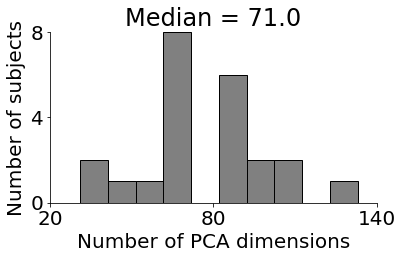

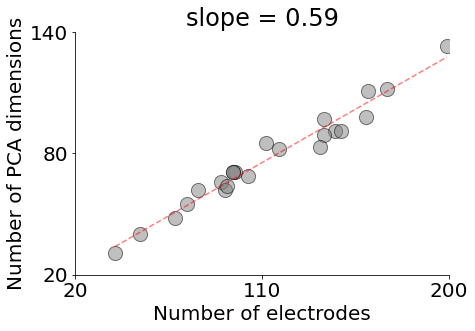

In [2]:
plt.figure()
ax = plt.subplot(111)
plt.hist(sc_df['numDimensions'],color='.5',edgecolor='k')
ax.set_xlabel('Number of PCA dimensions')
ax.set_ylabel('Number of subjects')
ax.set_title('Median = '+str(np.median(sc_df['numDimensions'])))
clean_fig()
plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2).astype('int'),fontsize=20)
save_fig(ret_idx_lbl+'-nDim')

x,y = C.plot_scatter(sc_df['n_obs'],sc_df['numDimensions'],s=200)
ax = plt.gca()
ax.set_xlabel('Number of electrodes')
ax.set_ylabel('Number of PCA dimensions')
slope, intercept, r_value, p_value, std_err = stats.linregress(sc_df['n_obs'],sc_df['numDimensions'])
ax.set_title('slope = '+str(np.round(slope,2)))
r_value, p_value = stats.spearmanr(x,y)
print('spearman corr',r_value,p_value)
clean_fig()
save_fig(ret_idx_lbl+'-nDim_v_nElc')

print('Average number of electrodes per subject:')
print(np.mean(sc_df['n_obs']))

#### How does within-condition RT variability relate to neural dynamics?

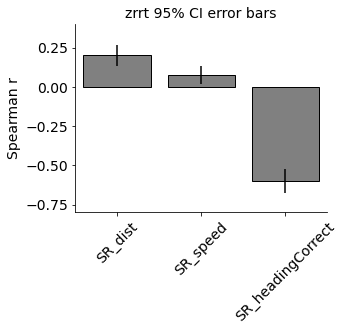

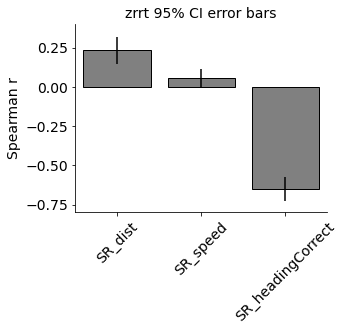

In [9]:
# distribution of zstats (non-param)
beh_var_lbl = 'zrrt'
stat_option = 'corr'#'corrPartial'
use_zstats=False
figsize=(5,5)

d_str='S'
C.sc_plotPopStats_reg(beh_var_lbl = beh_var_lbl,stat_option = stat_option,d_str=d_str,neu_feat_list=neu_feat_list,use_zstats=use_zstats,figsize=figsize)
save_fig(ret_idx_lbl+'-RTvsDynamics-S')

d_str='L'
C.sc_plotPopStats_reg(beh_var_lbl = beh_var_lbl,stat_option = stat_option,d_str=d_str,neu_feat_list=neu_feat_list,use_zstats=use_zstats,figsize=figsize)
save_fig(ret_idx_lbl+'-RTvsDynamics-L')


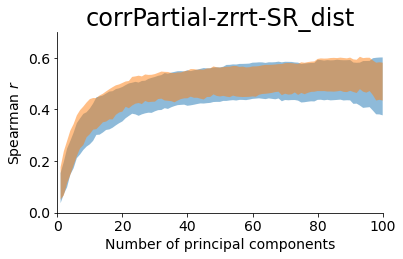

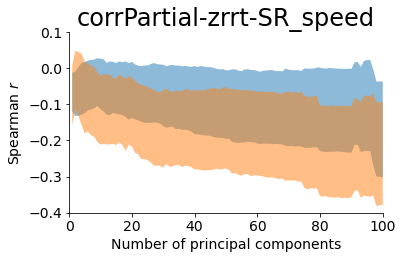

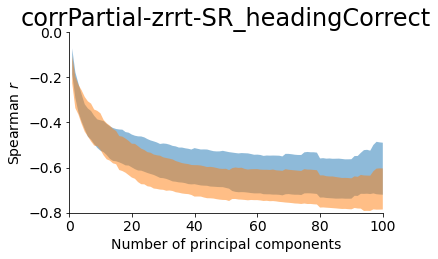

In [4]:
# what is the dimensionality of these measures?
C.sc_plotPopStats_cumPCA(num_dim = 100,beh_var_lbl = 'zrrt',neu_var_lbl = 'SR_dist',stat_option='corr',fsize_lbl = 14) # 'corrPartial'
save_fig(ret_idx_lbl+'-RTvsDist-byPCA')


C.sc_plotPopStats_cumPCA(num_dim = 100,beh_var_lbl = 'zrrt',neu_var_lbl = 'SR_speed',stat_option='corr',fsize_lbl = 14)
save_fig(ret_idx_lbl+'-RTvsSpeed-byPCA')

C.sc_plotPopStats_cumPCA(num_dim = 100,beh_var_lbl = 'zrrt',neu_var_lbl = 'SR_headingCorrect',stat_option='corr',fsize_lbl = 14)
save_fig(ret_idx_lbl+'-RTvsHeading-byPCA')

[2, 1, 6]
[2, 1, 5]


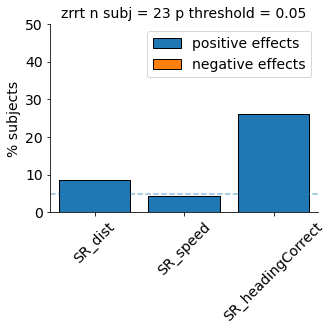

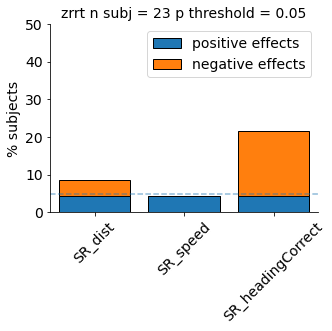

In [7]:
# counts analysis (per subject)
yL = (0,50)
p_thresh = 0.05
beh_var_lbl = 'zrrt'
stat_option = 'corr'#'corrPartial'

d_str='S'
plot_dictS = C.sc_plotPopStats_regCounts(beh_var_lbl = beh_var_lbl,p_thresh = p_thresh,stat_option = stat_option,\
                                         d_str=d_str,neu_feat_list=neu_feat_list,figsize=figsize)
plt.gca().set_ylim(yL)
save_fig(ret_idx_lbl+'-RTvsDynamics-Counts-S')

print(plot_dictS['n_obs'])

d_str='L'
plot_dictL = C.sc_plotPopStats_regCounts(beh_var_lbl = beh_var_lbl,p_thresh = p_thresh,stat_option = stat_option,\
                                         d_str=d_str,neu_feat_list=neu_feat_list,figsize=figsize)
plt.gca().set_ylim(yL)
save_fig(ret_idx_lbl+'-RTvsDynamics-Counts-L')
print(plot_dictL['n_obs'])



In [10]:
# Which effects are more sig than expected by chance across subjects?'
# here expected rate is 5%|

print('SHORT DELAY: Which effects are more sig than expected by chance across subjects?')
doChi2(plot_dictS)
print('\n')
print('LONG DELAY: Which effects are more sig than expected by chance across subjects?')
doChi2(plot_dictL)
        
        

SHORT DELAY: Which effects are more sig than expected by chance across subjects?


SR_dist
n_obs 2
chi2stat 0.6613272311212813 0.416


SR_speed
n_obs 1
chi2stat 0.02059496567505722 0.886


SR_headingCorrect
n_obs 6
chi2stat 21.53089244851258 0.0


LONG DELAY: Which effects are more sig than expected by chance across subjects?


SR_dist
n_obs 2
chi2stat 0.6613272311212813 0.416


SR_speed
n_obs 1
chi2stat 0.02059496567505722 0.886


SR_headingCorrect
n_obs 5
chi2stat 13.567505720823796 0.0


([0.41609177149580634, 0.8858878390266267, 0.0002301349901457952],
 ['SR_dist', 'SR_speed', 'SR_headingCorrect'])

#### How do within-condition RT variability effects co-vary with each other?

In [11]:
# define scatter funcitons
def plot_neu_scat_wrapper(C,sc_df,beh_var_lbl,stat_option,x_var,y_var,d_str,remove_zeros):
    if stat_option=='tstat':
        x_lbl = 'popReg'+d_str+'_'+beh_var_lbl+'_'+x_var+'_zstatnp'
        y_lbl = 'popReg'+d_str+'_'+beh_var_lbl+'_'+y_var+'_zstatnp'
    elif stat_option=='corr':
        x_lbl = 'popCorr'+d_str+'_'+beh_var_lbl+'_'+x_var+'_zstatnp'
        y_lbl = 'popCorr'+d_str+'_'+beh_var_lbl+'_'+y_var+'_zstatnp'    
    elif stat_option=='corrPartial':
        x_lbl = 'popCorrPartial'+d_str+'_'+beh_var_lbl+'_'+x_var+'_zstatnp'
        y_lbl = 'popCorrPartial'+d_str+'_'+beh_var_lbl+'_'+y_var+'_zstatnp'   

    C.plot_scatter(sc_df[x_lbl],sc_df[y_lbl],\
                   color = '0.5',use_spearman=True,s=200,remove_zeros=remove_zeros);
    ax = plt.gca()
    ax.set_xlabel(x_var+'-'+d_str)
    ax.set_ylabel(y_var+'-'+d_str)
    

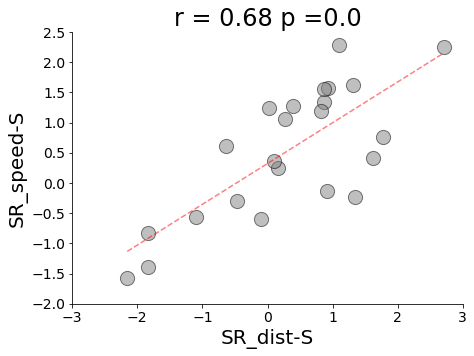

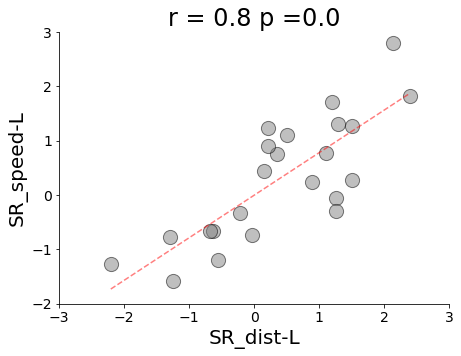

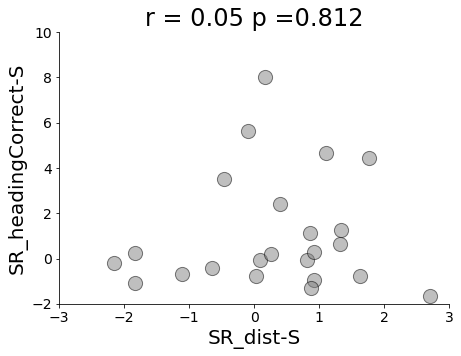

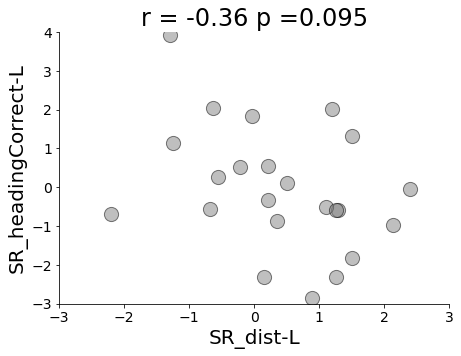

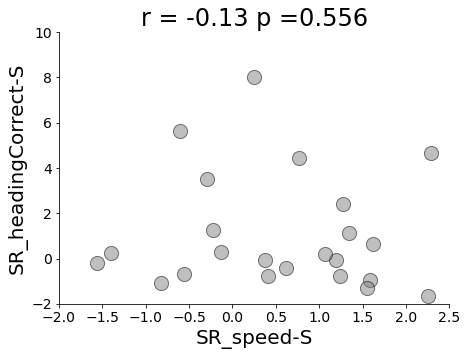

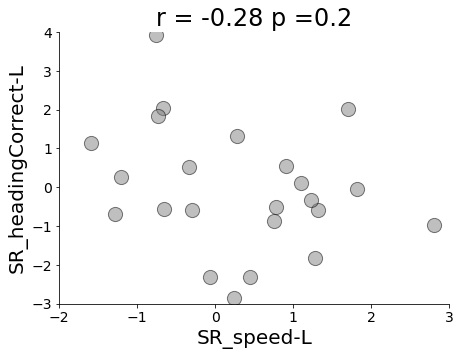

In [12]:
#scatter between neural features
beh_var_lbl = 'zrrt'
stat_option = 'corr' #corrPartial
remove_zeros = False

for n in range(0,len(neu_feat_list)):
    for n2 in range(n+1,len(neu_feat_list)):
        if neu_feat_list[n] == neu_feat_list[n2]:
            continue
    
        plot_neu_scat_wrapper(C,sc_df,beh_var_lbl = beh_var_lbl,stat_option = stat_option,x_var = neu_feat_list[n],\
                         y_var = neu_feat_list[n2],d_str = 'S',remove_zeros = remove_zeros) 
        plot_neu_scat_wrapper(C,sc_df,beh_var_lbl = beh_var_lbl,stat_option = stat_option,x_var =neu_feat_list[n],\
                         y_var = neu_feat_list[n2],d_str = 'L',remove_zeros = remove_zeros) 


#### How do dynamics vary between conditions?

{'n_tot': [23, 23, 23, 23, 23, 23, 23], 'n_obs': [5, 6, 12, 11, 7, 18, 8], 'n_exp': [1.1500000000000001, 1.1500000000000001, 1.1500000000000001, 1.1500000000000001, 1.1500000000000001, 1.1500000000000001, 1.1500000000000001], 'n_obs_pos': [0, 0, 12, 1, 5, 1, 6], 'n_obs_neg': [5, 6, 0, 10, 2, 17, 2], 'lbls': ['SR_distMean', 'SR_speedMean', 'SR_headingCorrectMean', 'S0reg', 'S0var', 'Streg', 'Stvar']}


SR_distMean
n_obs 5
chi2stat 13.567505720823796 0.0


SR_speedMean
n_obs 6
chi2stat 21.53089244851258 0.0


SR_headingCorrectMean
n_obs 12
chi2stat 107.75514874141875 0.0


S0reg
n_obs 11
chi2stat 88.8077803203661 0.0


S0var
n_obs 7
chi2stat 31.324942791762005 0.0


Streg
n_obs 18
chi2stat 259.88329519450804 0.0


Stvar
n_obs 8
chi2stat 42.949656750572075 0.0


FDR-corrected p values
[['SR_distMean' '0.0']
 ['SR_speedMean' '0.0']
 ['SR_headingCorrectMean' '0.0']
 ['S0reg' '0.0']
 ['S0var' '0.0']
 ['Streg' '0.0']
 ['Stvar' '0.0']]


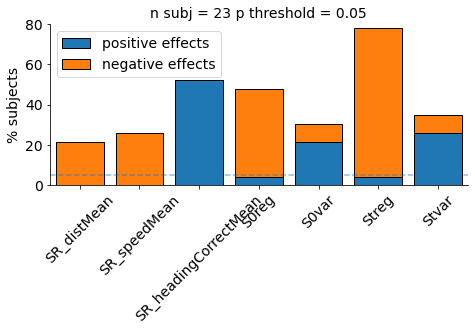

In [13]:
resid_str = ''
neu_feat_list = ['SR_distMean','SR_speedMean','SR_headingCorrectMean','S0reg','S0var','Streg','Stvar']#
# control list:
#neu_feat_list = ['SR_distStd','SR_speedStd','SR_headingCorrectStd','S0','St']
use_zstats=True
# distribution of zstats (non-param)
#C.sc_plotPopStats_byDelay(figsize=(8,5),use_zstats=use_zstats,neu_feat_list=neu_feat_list,resid_str=resid_str)


plot_dict = C.sc_plotPopStats_byDelayCounts(figsize=(7,5),p_thresh=0.05,neu_feat_list=neu_feat_list,resid_str=resid_str,use_zstats=use_zstats)
plt.gca().set_ylim((0,80))
save_fig(ret_idx_lbl+'-DelayvsDynamics-Counts')

print(plot_dict)
p_list,lbls_list = doChi2(plot_dict)

fdr_wrapper(p_list,lbls_list)


#### How delay-related changes in dynamics map on to delay-related changes in RTs?

In [14]:
# scatters between delay-related difference in behavior and delay-related neural differences
def plot_beh_violin_wrapper(C,sc_df,beh_var_lbl,use_zstats,neu_feat_list,resid_str = 'Resid',s_idx=None,p_thresh=0.05,beh_cutoff = None):
    
    # parse subj idx (for subgroup analyses)
    if s_idx is None:
        s_idx = np.ones(len(sc_df)).astype('bool')
        

    text_lbls = sc_df['subj'].to_numpy()
    
    
    # containers 
    tstat_list = []
    pvals_list = []
        
    
    for n in neu_feat_list:
        #define neural label
        if use_zstats==False:
            n_lbl = 'popByDelay'+resid_str+'_'+n+'_diff'
            ylbl = 'diff scoret'
        elif use_zstats==True:
            n_lbl = 'popByDelay'+resid_str+'_'+n+'_zstatnp'
            ylbl = 'z stat (non param)'
        p_lbl = 'popByDelay'+resid_str+'_'+n+'_pvalnp'
        
        
        # collect neural data and behavioral data
        neu = sc_df[n_lbl][s_idx]
        beh = sc_df[beh_var_lbl][s_idx]
        #print(sc_df['subj'].to_numpy()[beh>=beh_cutoff])
               
        # get data for each group based on "beh_cutoff"
        if beh_cutoff is None:
            # do a median split 
            neu_grp_A = neu[beh<np.median(beh)]
            neu_grp_B = neu[beh>=np.median(beh)]
        else:
            # split by group
            neu_grp_A = neu[beh<=beh_cutoff]
            neu_grp_B = neu[beh>beh_cutoff]
            
        # t-test (independent samples, unequal variance)
        tstat,pval = stats.ttest_ind(neu_grp_B,neu_grp_A,equal_var=False)
        tstat_list.append(tstat)
        pvals_list.append(pval)
        
        # plot violin
        f = plt.figure()
        ax = plt.subplot(111)
        vp = ax.violinplot((neu_grp_A,neu_grp_B))
        # plot individual markers
        ax.plot(np.ones(len(neu_grp_A)),neu_grp_A,'o',alpha=0.5)
        ax.plot(np.ones(len(neu_grp_B))+1,neu_grp_B,'o',alpha=0.5)
        
        for i in np.arange(0,len(vp['bodies'])):
            vp['bodies'][i].set_facecolor('C'+str(i))
            vp['bodies'][i].set_edgecolor('k')
            vp['bodies'][i].set_alpha(0.5)
        vp['cmins'].set_color('k')
        vp['cbars'].set_color('k')
        vp['cmaxes'].set_color('k')
    
        ax.set_xlabel('$\Delta$'+beh_var_lbl)
        ax.set_ylabel(n,fontsize=20)
        ax.set_xticks([1,2])
        ax.set_title('t = '+str(np.round(tstat,2))+' p = '+str(np.round(pval,3)))
        #save_fig(ret_idx_lbl+'-DelayvsDynamics-Scatter-'+beh_var_lbl+'-'+n)
        
        
    # [ ] plot bar plot indicating tstat each feature
    f = plt.figure()
    ax = plt.subplot(111)
    #print(rvals)
    ax.bar(np.arange(0,len(neu_feat_list)),np.array(tstat_list),color = '0.5',edgecolor='k')
    ax.set_xticks(np.arange(0,len(neu_feat_list)))
    ax.set_xticklabels(neu_feat_list,rotation=90)



# scatters between delay-related difference in behavior and delay-related neural differences
def plot_beh_scat_wrapper(C,sc_df,beh_var_lbl,use_zstats,remove_zeros,neu_feat_list,resid_str = 'Resid',s_idx=None,plot_text = True,p_thresh=0.05,s_idx_lbl=''):
    
    # parse subj idx (for subgroup analyses)
    if s_idx is None:
        s_idx = np.ones(len(sc_df)).astype('bool')
        

    text_lbls = sc_df['subj'].to_numpy()
    
    
    # containers 
    rvals = []
    pvals = []
        
    
    for n in neu_feat_list:
        #define neural label
        if use_zstats==False:
            n_lbl = 'popByDelay'+resid_str+'_'+n+'_diff'
            ylbl = 'diff score'
        elif use_zstats==True:
            n_lbl = 'popByDelay'+resid_str+'_'+n+'_zstatnp'
            ylbl = 'z stat (non param)'
        p_lbl = 'popByDelay'+resid_str+'_'+n+'_pvalnp'
        
        
        # collect r vlas and p-vals
        r_value,p_value = stats.spearmanr(sc_df[beh_var_lbl][s_idx],sc_df[n_lbl][s_idx])
        rvals.append(r_value), pvals.append(p_value)
        
        
            
        # plot all data (without text) 
        if plot_text == True:
            C.plot_scatter(sc_df[beh_var_lbl][s_idx],sc_df[n_lbl][s_idx],\
                       color = '0.5',use_spearman=True,s=200,remove_zeros=remove_zeros,text_lbls=text_lbls[s_idx]);
        else:
            C.plot_scatter(sc_df[beh_var_lbl][s_idx],sc_df[n_lbl][s_idx],\
                       color = '0.5',use_spearman=True,s=200,remove_zeros=remove_zeros,text_lbls=None);

            
        ax = plt.gca()
        
        # plot sig electrodes w text
        sig_idx = sc_df[p_lbl].to_numpy()<p_thresh
#         if plot_text==True:
#             C.plot_scatter(sc_df[beh_var_lbl][s_idx&sig_idx],sc_df[n_lbl][s_idx&sig_idx],ax=ax,\
#                        color = 'C1',use_spearman=True,s=200,plotLine=False,remove_zeros=remove_zeros,text_lbls=text_lbls[s_idx&sig_idx]);
#         else:
#             C.plot_scatter(sc_df[beh_var_lbl][s_idx&sig_idx],sc_df[n_lbl][s_idx&sig_idx],ax=ax,\
#                        color = 'C1',use_spearman=True,s=200,plotLine=False,remove_zeros=remove_zeros,text_lbls=None);

        
        
        
        ax = plt.gca()
        ax.set_xlabel('$\Delta$'+beh_var_lbl)
        ax.set_ylabel('$\Delta$'+n)
        clean_fig(apply_int=False)
        save_fig(ret_idx_lbl+'-DelayvsDynamics-Scatter-'+beh_var_lbl+'-'+n+s_idx_lbl)
        
        
    # [ ] plot bar plot indicating spearman r for each feature
    f = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    #print(rvals)
    ax.bar(np.arange(0,len(neu_feat_list)),np.array(rvals),color = '0.5',edgecolor='k')
    ax.set_xticks(np.arange(0,len(neu_feat_list)))
    ax.set_xticklabels(neu_feat_list,rotation=90)
    #clean_fig(apply_int=False)
    save_fig(ret_idx_lbl+'-DelayvsDynamics-Bar-'+beh_var_lbl+s_idx_lbl)
    
    # print fdr-corrected p vals
    fdr_wrapper(pvals,neu_feat_list)

    


#### How delay-related changes in dynamics map on to delay-related changes in changes in RT distributions?



FDR-corrected p values
[['SR_distMean' '0.879']
 ['SR_speedMean' '0.635']
 ['SR_headingCorrectMean' '0.0']
 ['S0reg' '0.635']
 ['S0var' '0.514']
 ['Streg' '0.635']
 ['Stvar' '0.635']]


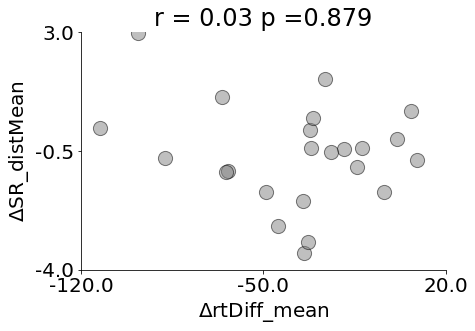

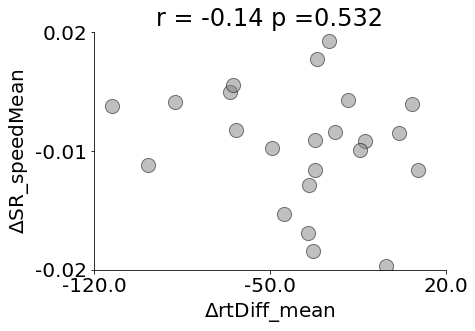

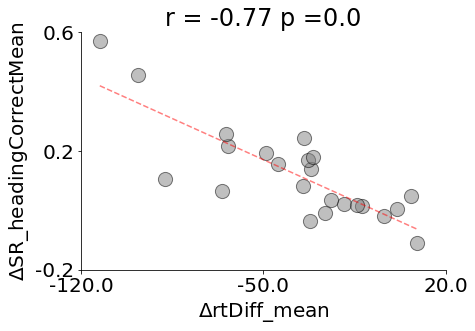

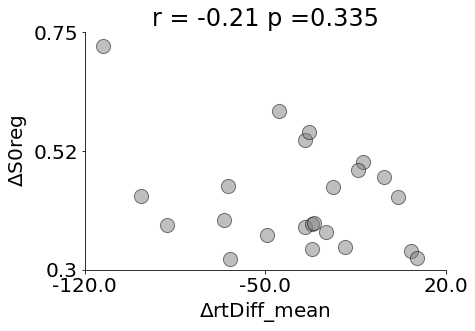

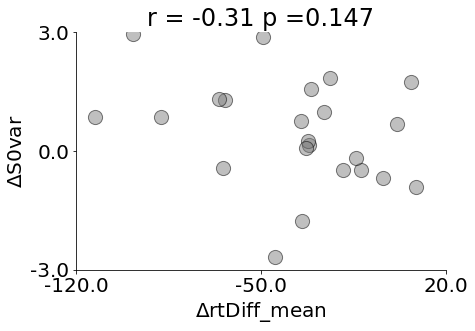

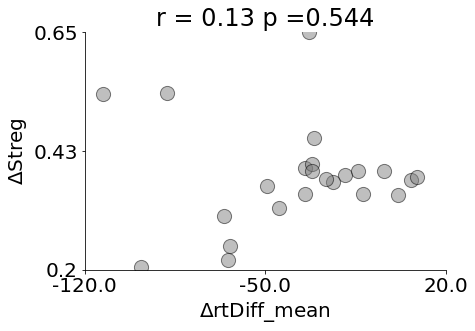

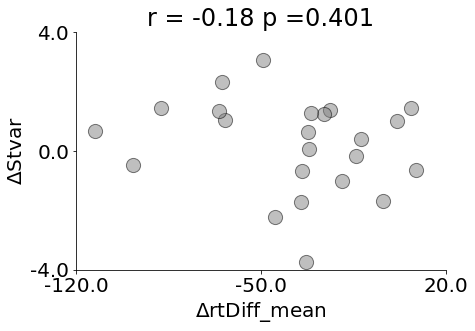

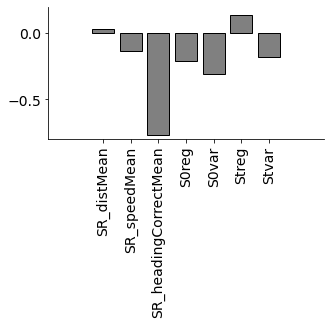

In [15]:
# delay-related change in mean RT
resid_str = ''
use_zstats=False
plot_text =False
plot_beh_scat_wrapper(C,sc_df,beh_var_lbl='rtDiff_mean',\
                      use_zstats=use_zstats,remove_zeros=False,neu_feat_list=neu_feat_list,resid_str=resid_str,plot_text=plot_text)


#[ ] Implement partial correlation analysis here



FDR-corrected p values
[['SR_distMean' '0.793']
 ['SR_speedMean' '0.58']
 ['SR_headingCorrectMean' '0.943']
 ['S0reg' '0.1']
 ['S0var' '0.1']
 ['Streg' '0.367']
 ['Stvar' '0.1']]


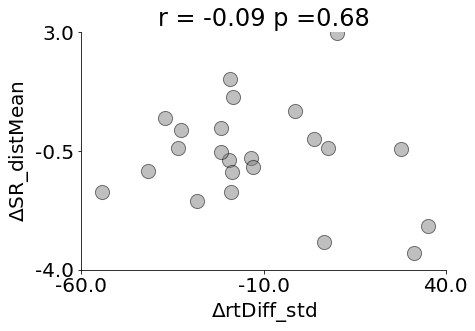

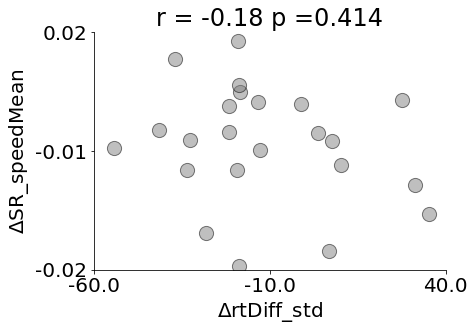

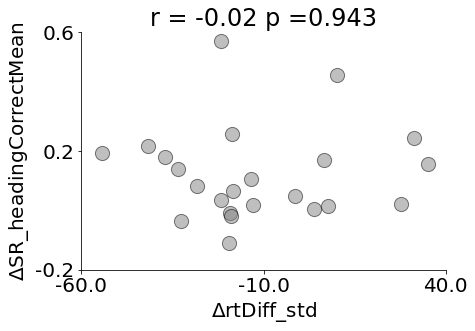

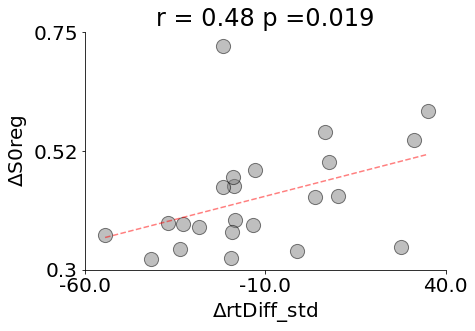

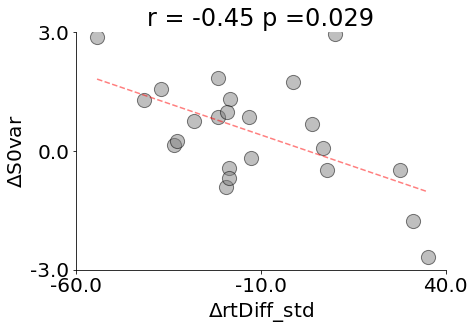

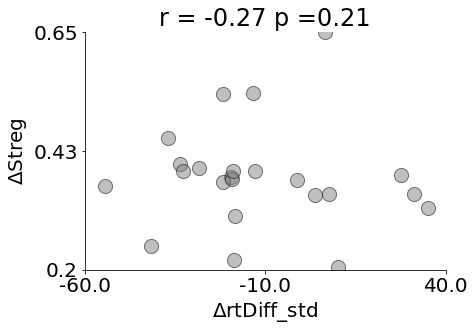

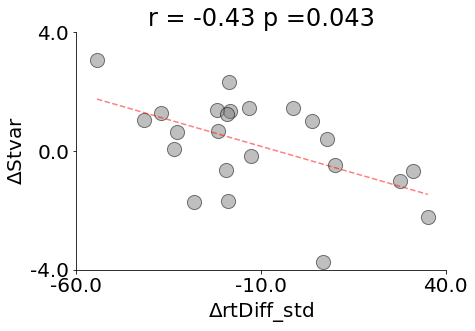

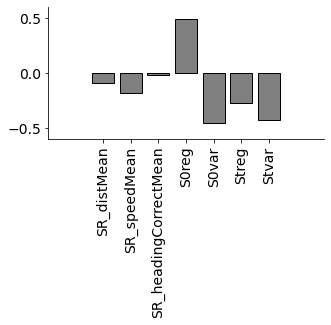

In [16]:
# delay-related change in std RT
plot_beh_scat_wrapper(C,sc_df,beh_var_lbl='rtDiff_std',use_zstats=use_zstats,remove_zeros=False,neu_feat_list=neu_feat_list,\
                      resid_str=resid_str,plot_text=plot_text)



FDR-corrected p values
[['SR_distMean' '0.038']
 ['SR_speedMean' '0.134']
 ['SR_headingCorrectMean' '0.9']
 ['S0reg' '0.762']
 ['S0var' '0.113']
 ['Streg' '0.797']
 ['Stvar' '0.134']]


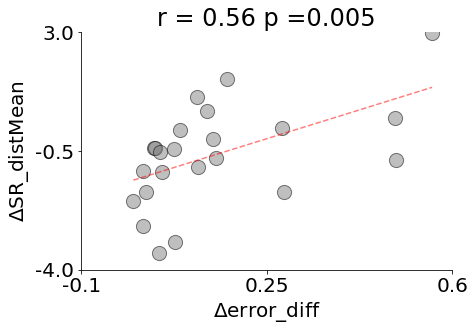

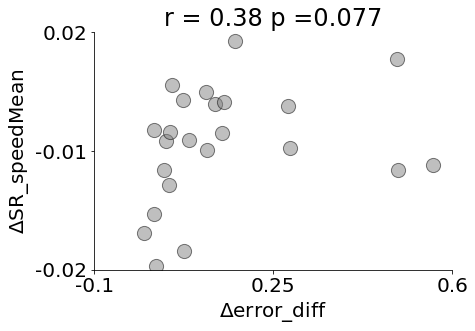

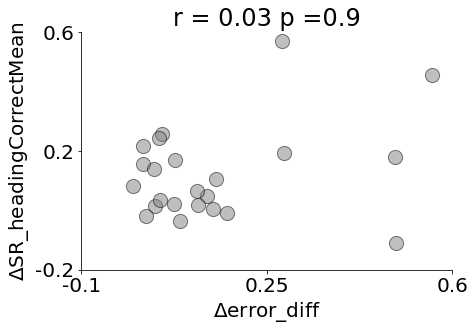

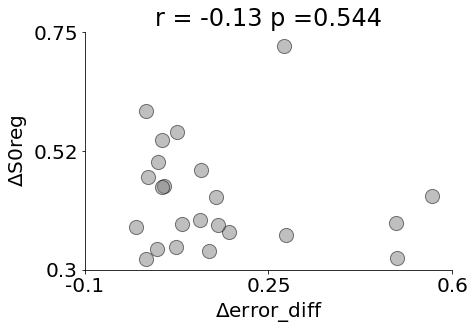

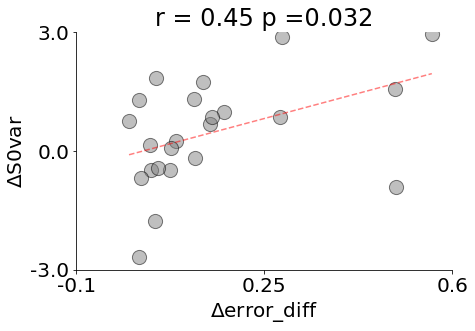

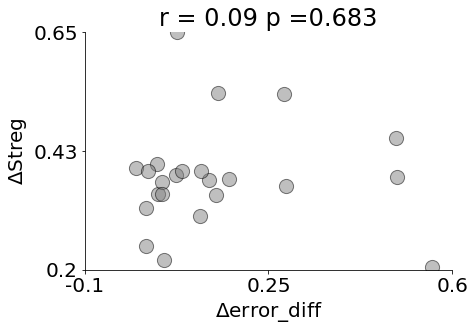

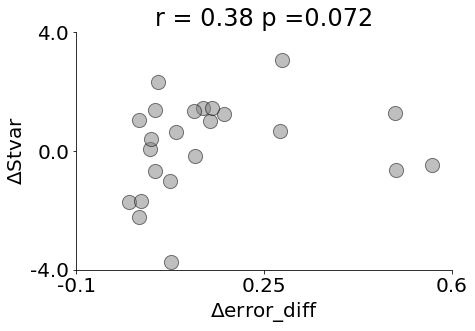

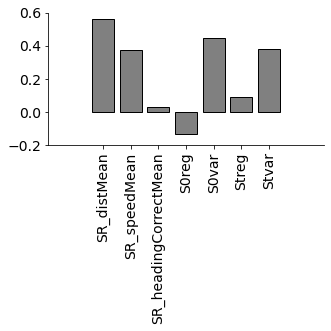

In [17]:
# delay-related change in error rate
plot_beh_scat_wrapper(C,sc_df,beh_var_lbl='error_diff',use_zstats=use_zstats,remove_zeros=False,neu_feat_list=neu_feat_list,\
                      resid_str=resid_str,plot_text=plot_text)

In [18]:
# partial spearman correlations 
import pingouin as pg

# # RT mean vs. SR_heading correct (correcting for SR_distance)
# n = 'SR_headingCorrectMean'
# n_lbl = 'popByDelay'+'_'+n+'_diff'

# c = 'SR_distMean'
# c_lbl = 'popByDelay'+'_'+c+'_diff'

# beh_var_lbl = 'rtDiff_mean'

# corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
# print(corrstats)


# # RT distance vs. error rate (correcting for SR_heading)

# n = 'SR_distMean'
# n_lbl = 'popByDelay'+'_'+n+'_diff'

# c = 'SR_headingCorrectMean'
# c_lbl = 'popByDelay'+'_'+c+'_diff'

# beh_var_lbl ='error_diff'

# corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
# print(corrstats)


# S0reg vs. paramsS (correcting for SR_heading)

n = 'S0reg'
n_lbl = 'popByDelay'+'_'+n+'_diff'

c = 'SR_headingCorrectMean'
c_lbl = 'popByDelay'+'_'+c+'_diff'

beh_var_lbl ='paramsDiff_S'

corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
print(corrstats)


# SR_heading vs. paramsS (correcting for S0reg)

n = 'SR_headingCorrectMean'
n_lbl = 'popByDelay'+'_'+n+'_diff'

c = 'S0reg'
c_lbl = 'popByDelay'+'_'+c+'_diff'

beh_var_lbl ='paramsDiff_S'

corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
print(corrstats)


# paramsDiff_S vs. SR_heading (correcting for paramsDiff_B)

n = 'SR_headingCorrectMean'
n_lbl = 'popByDelay'+'_'+n+'_diff'
c_lbl = 'paramsDiff_B'

beh_var_lbl ='paramsDiff_S'

corrstats = pg.partial_corr(data = sc_df, x=beh_var_lbl,y =n_lbl,covar = c_lbl,method='spearman')
print(corrstats)


# paramsDiff_B vs. SR_heading (correcting for paramsDiff_S)

n = 'SR_headingCorrectMean'
n_lbl = 'popByDelay'+'_'+n+'_diff'
c_lbl = 'paramsDiff_S'

beh_var_lbl ='paramsDiff_B'

corrstats = pg.partial_corr(data = sc_df, x=beh_var_lbl,y =n_lbl,covar = c_lbl,method='spearman')
print(corrstats)









           n         r         CI95%    p-val
spearman  23  0.541674  [0.16, 0.78]  0.00922
           n         r         CI95%     p-val
spearman  23  0.518331  [0.12, 0.77]  0.013462
           n         r          CI95%    p-val
spearman  23  0.415859  [-0.01, 0.71]  0.05424
           n         r         CI95%     p-val
spearman  23  0.472158  [0.06, 0.75]  0.026506


#### How delay-related changes in dynamics map on to delay-related changes in model parameters (t-tests)?

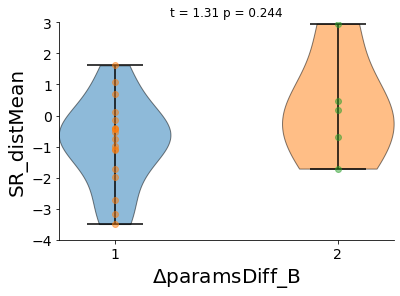

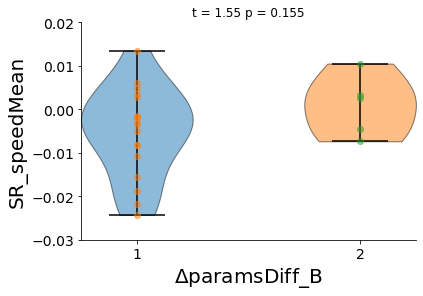

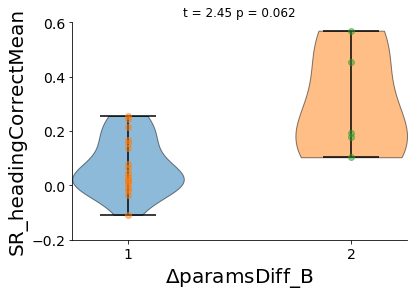

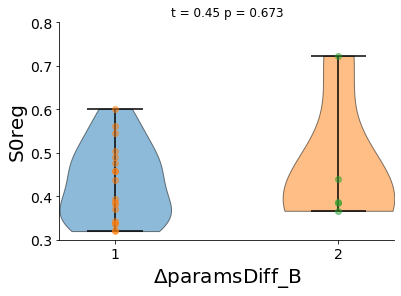

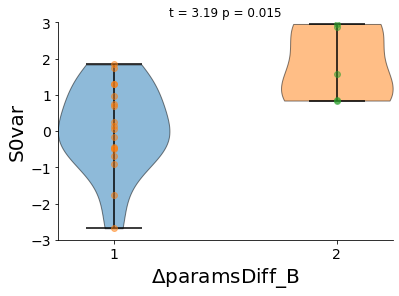

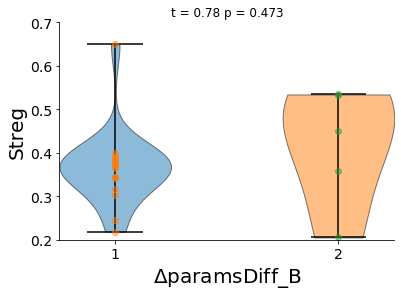

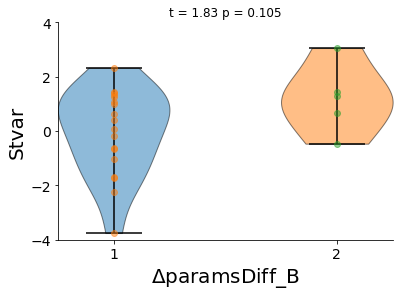

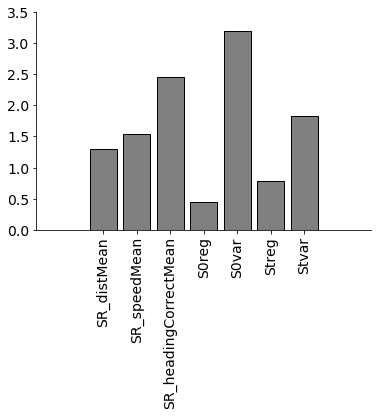

In [9]:
use_zstats = False
plot_beh_violin_wrapper(C,sc_df,beh_var_lbl='paramsDiff_B',use_zstats=use_zstats,\
                        neu_feat_list=neu_feat_list,resid_str = '',s_idx=None,beh_cutoff = 0.1)
    

#### How delay-related changes in dynamics map on to delay-related changes in model parameters?



FDR-corrected p values
[['SR_distMean' '0.833']
 ['SR_speedMean' '0.833']
 ['SR_headingCorrectMean' '0.021']
 ['S0reg' '0.833']
 ['S0var' '0.833']
 ['Streg' '0.833']
 ['Stvar' '0.833']]


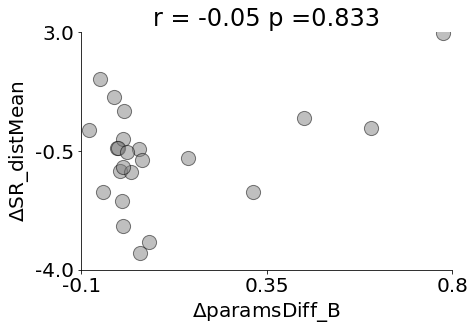

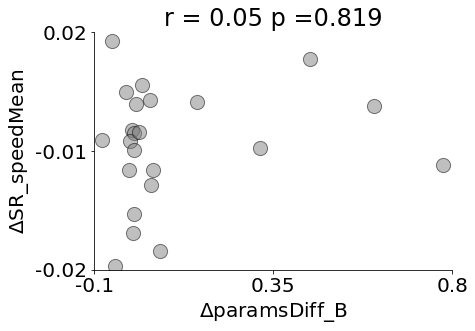

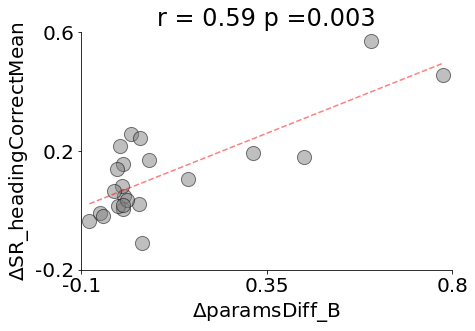

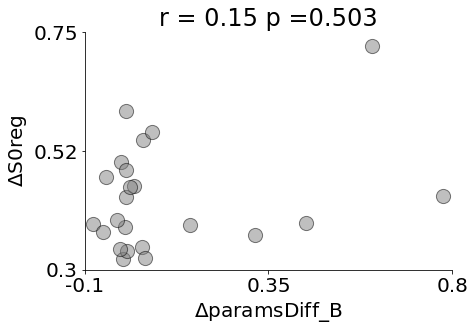

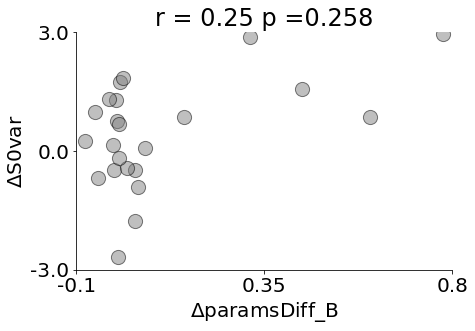

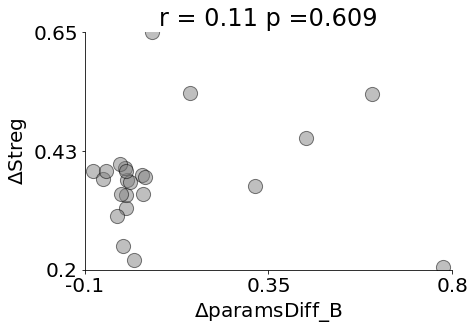

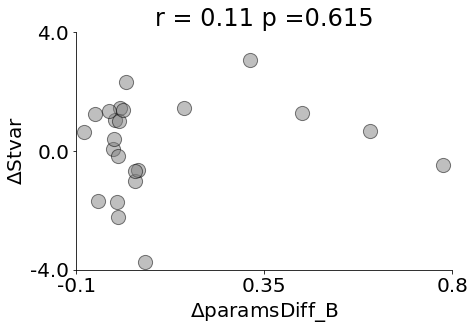

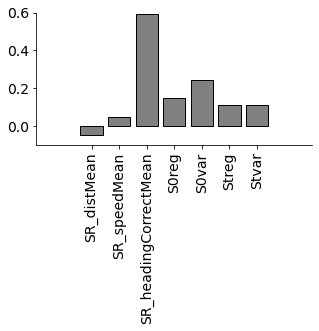

In [19]:
# delay-related change in predictive bias (B)
resid_str = ''
use_zstats=False
plot_text =False
s_idx = None
plot_beh_scat_wrapper(C,sc_df,beh_var_lbl='paramsDiff_B',\
                      use_zstats=use_zstats,remove_zeros=False,neu_feat_list=neu_feat_list,resid_str=resid_str,s_idx=s_idx,plot_text=plot_text)



FDR-corrected p values
[['SR_distMean' '0.499']
 ['SR_speedMean' '0.59']
 ['SR_headingCorrectMean' '0.021']
 ['S0reg' '0.021']
 ['S0var' '0.499']
 ['Streg' '0.483']
 ['Stvar' '0.483']]


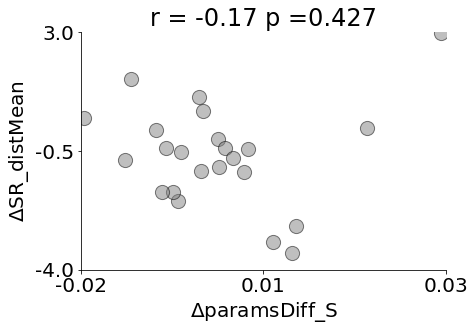

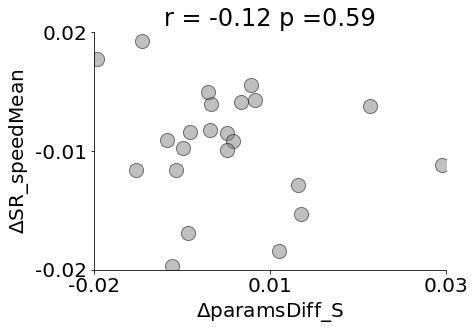

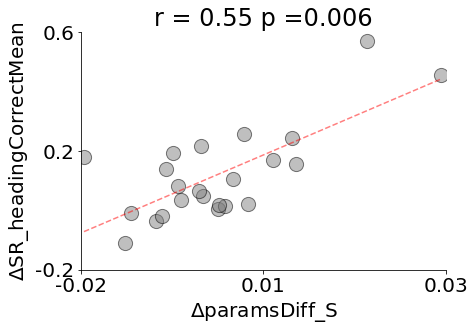

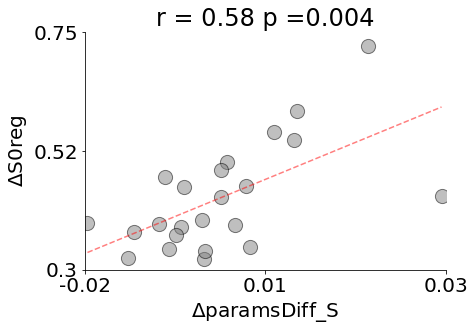

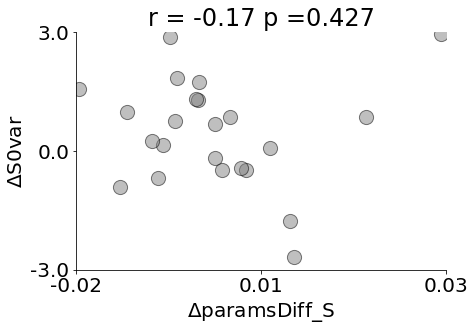

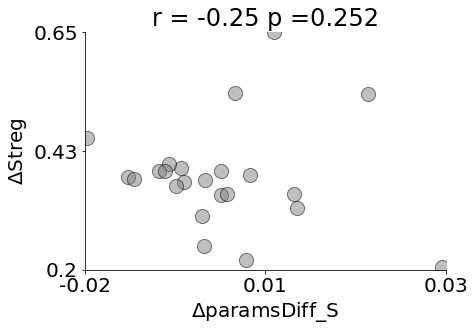

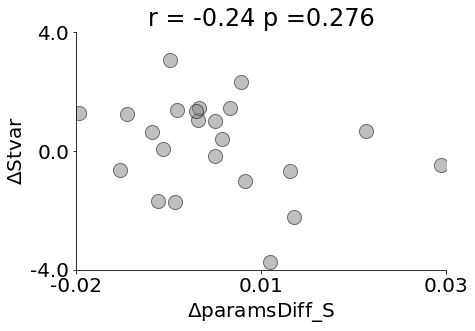

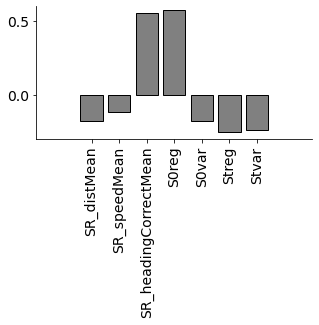

In [20]:
# delay-related change  in reactive bias (S)
resid_str = ''
use_zstats=False
plot_text =False
s_idx = None
plot_beh_scat_wrapper(C,sc_df,beh_var_lbl='paramsDiff_S',\
                      use_zstats=use_zstats,remove_zeros=False,neu_feat_list=neu_feat_list,resid_str=resid_str,s_idx=s_idx,plot_text=plot_text)

In [23]:
# CONTROL ANALYSIS: Network dynamics vs. Model params 
#(controlling for Model-free RT measures - RT MEAN)

#Trajectory vs. Predictive Bias (controlling for rtDiff_mean) - Sig.

n = 'SR_headingCorrectMean'
n_lbl = 'popByDelay'+'_'+n+'_diff'
c_lbl = 'rtDiff_mean'


beh_var_lbl ='paramsDiff_B'
corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
print(corrstats)


#Trajectory vs. Reactive Bias (controlling for rtDiff_mean) - N.S.
n = 'SR_headingCorrectMean'
n_lbl = 'popByDelay'+'_'+n+'_diff'
c_lbl = 'rtDiff_mean'


beh_var_lbl ='paramsDiff_S'
corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
print(corrstats)


#Peri-stim state vs. Reactive Bias (controlling for rtDiff_mean) - N.S.
n = 'S0reg'
n_lbl = 'popByDelay'+'_'+n+'_diff'
c_lbl = 'rtDiff_mean'


beh_var_lbl ='paramsDiff_S'
corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
print(corrstats)




           n         r         CI95%     p-val
spearman  23  0.582413  [0.21, 0.81]  0.004454
           n         r          CI95%     p-val
spearman  23  0.368478  [-0.06, 0.68]  0.091526
           n         r         CI95%  p-val
spearman  23  0.550027  [0.17, 0.79]  0.008


In [27]:
# CONTROL ANALYSIS: Network dynamics vs. Model params 
#(controlling for Model-free RT measures - RT STD)

#Trajectory vs. Predictive Bias (controlling for rtDiff_stf) - Sig.

n = 'SR_headingCorrectMean'
n_lbl = 'popByDelay'+'_'+n+'_diff'
c_lbl = 'rtDiff_std'


beh_var_lbl ='paramsDiff_B'
corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
print(corrstats)


#Trajectory vs. Reactive Bias (controlling for rtDiff_mean) - N.S.
n = 'SR_headingCorrectMean'
n_lbl = 'popByDelay'+'_'+n+'_diff'
c_lbl = 'rtDiff_std'


beh_var_lbl ='paramsDiff_S'
corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
print(corrstats)


#Peri-stim state vs. Reactive Bias (controlling for rtDiff_mean) - N.S.
n = 'S0reg'
n_lbl = 'popByDelay'+'_'+n+'_diff'
c_lbl = 'rtDiff_std'


beh_var_lbl ='paramsDiff_S'
corrstats = pg.partial_corr(data = sc_df, x=n_lbl,y =beh_var_lbl,covar = c_lbl,method='spearman')
print(corrstats)


           n         r         CI95%    p-val
spearman  23  0.596898  [0.23, 0.81]  0.00336
           n         r         CI95%     p-val
spearman  23  0.808497  [0.59, 0.92]  0.000005
           n         r          CI95%     p-val
spearman  23  0.374343  [-0.06, 0.69]  0.086092




FDR-corrected p values
[['SR_distMean' '0.107']
 ['SR_speedMean' '0.742']
 ['SR_headingCorrectMean' '0.022']
 ['S0reg' '0.022']
 ['S0var' '0.224']
 ['Streg' '0.235']
 ['Stvar' '0.378']]


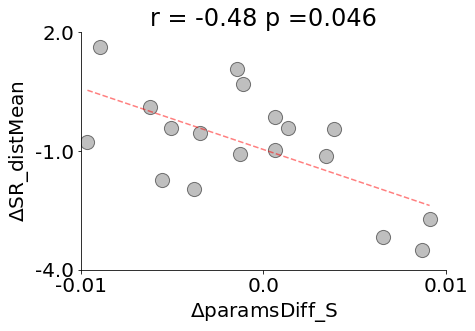

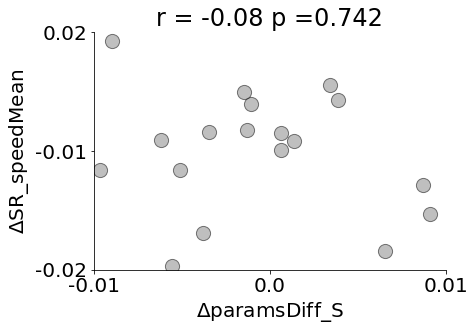

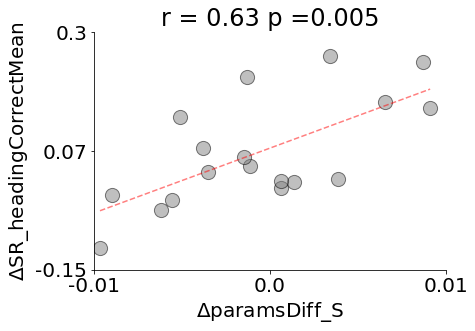

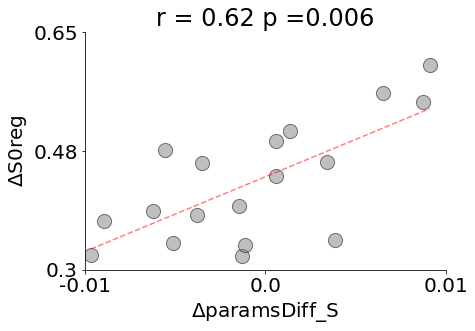

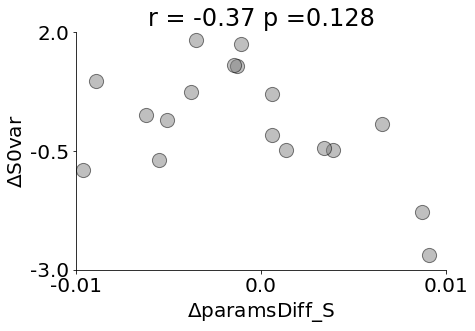

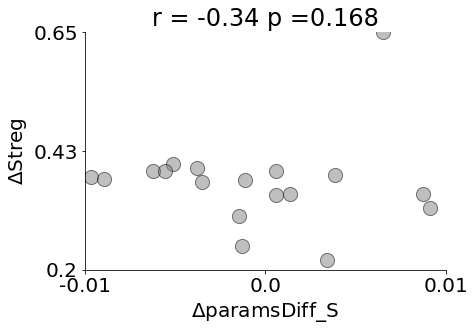

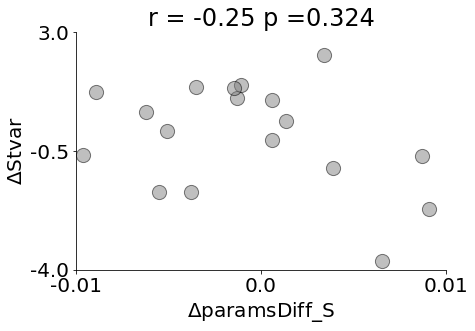

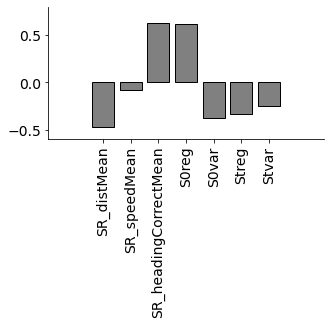

In [26]:
#correlation with paramsDiff_S for subjects that didnt show large changes in bias
s_idx = sc_df.eval('paramsDiff_B<=0.1')
plot_beh_scat_wrapper(C,sc_df,beh_var_lbl='paramsDiff_S',\
                      use_zstats=use_zstats,remove_zeros=False,neu_feat_list=neu_feat_list,resid_str=resid_str,s_idx=s_idx,plot_text=plot_text,s_idx_lbl='_lowBiasSubj')



FDR-corrected p values
[['SR_distMean' '0.293']
 ['SR_speedMean' '0.692']
 ['SR_headingCorrectMean' '0.569']
 ['S0reg' '0.692']
 ['S0var' '0.671']
 ['Streg' '0.804']
 ['Stvar' '0.692']]


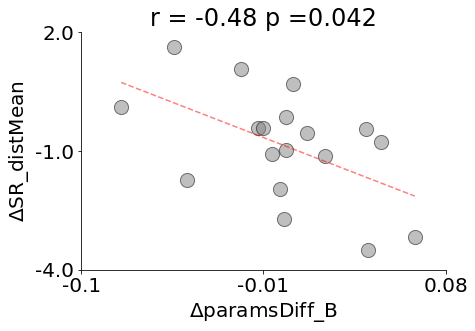

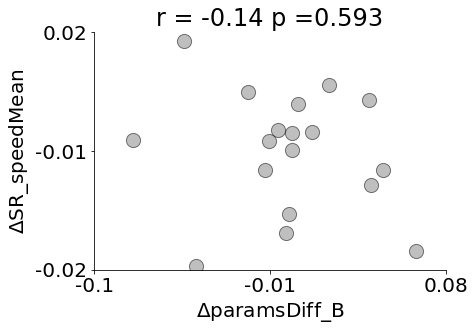

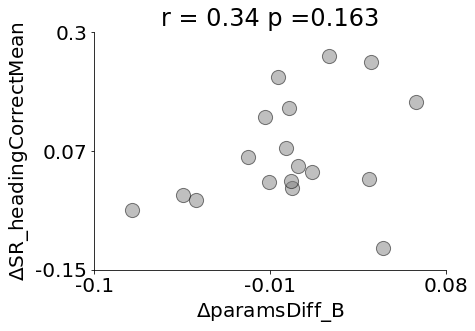

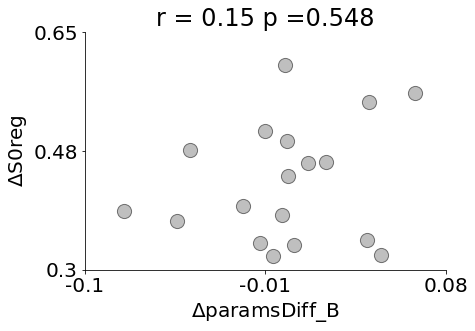

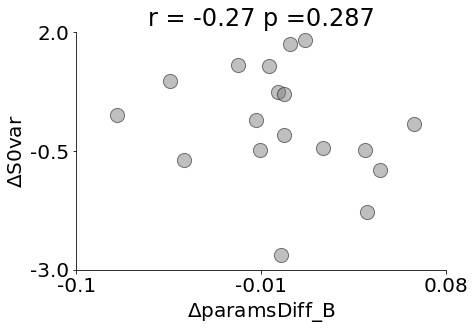

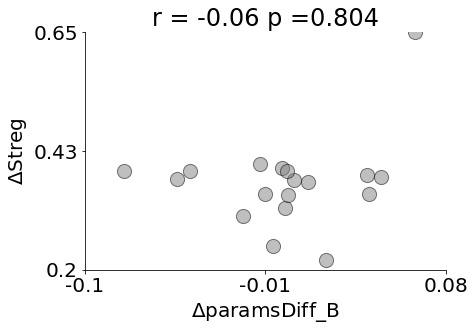

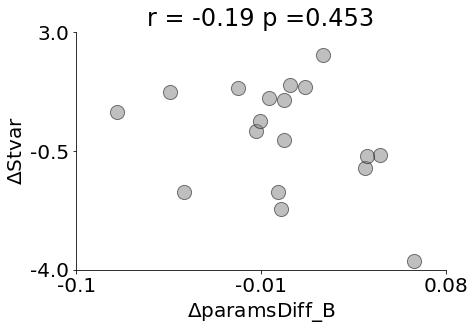

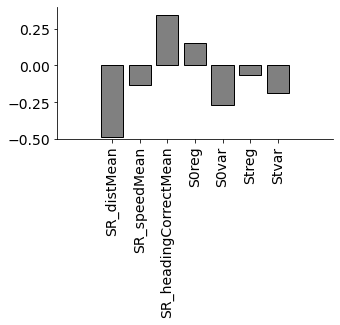

In [12]:
# delay-related correlation with bias parameter after removing outliers
s_idx = sc_df.eval('paramsDiff_B<=0.1')
plot_beh_scat_wrapper(C,sc_df,beh_var_lbl='paramsDiff_B',\
                      use_zstats=use_zstats,remove_zeros=False,neu_feat_list=neu_feat_list,resid_str=resid_str,s_idx=s_idx,plot_text=plot_text,s_idx_lbl='_lowBiasSubj')